In [1]:
import os
import cv2 as cv
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
def display(image, title):
    plt.title(title)
    plt.imshow(cv.cvtColor(image, cv.COLOR_BGR2RGB))
    plt.show()

In [3]:
def display_hist(image, title):
    plt.figure()
    plt.title(title)
    plt.hist(image.ravel(),256,[0,256])
    plt.show()

(500, 500, 3)


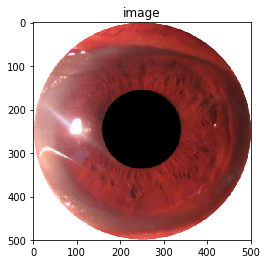

In [4]:
image = cv.imread('../Data_ext/ada/ada_001.JPG')
print(image.shape)
display(image,'image')

b,g,r = cv.split(image)

pd.DataFrame(np.asarray(b)).to_csv('./blue.csv',header=False, index=False)
pd.DataFrame(np.asarray(g)).to_csv('./green.csv',header=False, index=False)
pd.DataFrame(np.asarray(r)).to_csv('./red.csv',header=False, index=False)

(500, 500)


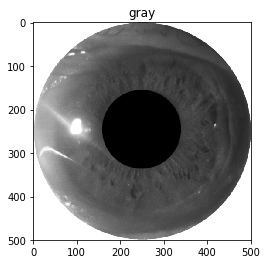

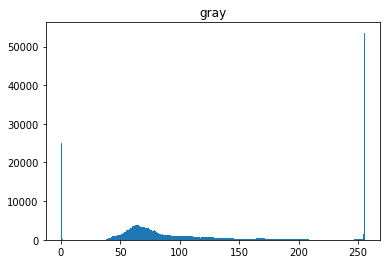

In [5]:
gray = cv.cvtColor(image, cv.COLOR_BGR2GRAY)
print(gray.shape)
display(gray, 'gray')

pd.DataFrame(np.asarray(gray)).to_csv('./grayscale.csv',header=False, index=False)

display_hist(gray,'gray')

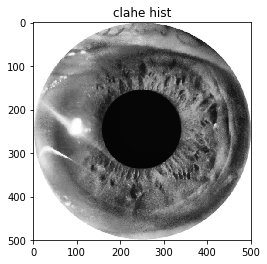

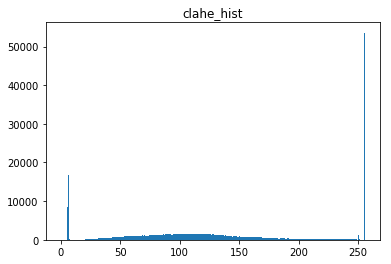

In [6]:
clahe = cv.createCLAHE(clipLimit=5.0, tileGridSize = (5,5))
clahe_img = clahe.apply(gray)
display(clahe_img, 'clahe hist')

pd.DataFrame(np.asarray(clahe_img)).to_csv('./hist_clahe.csv',header=False, index=False)

display_hist(clahe_img, 'clahe_hist')

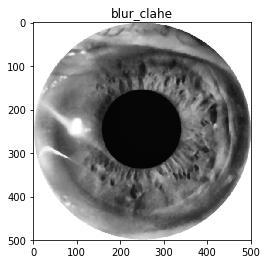

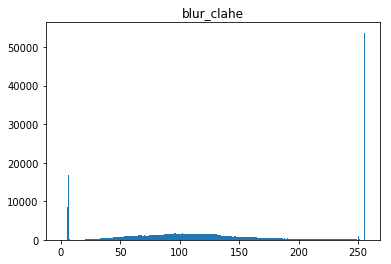

In [7]:
blur_clahe = cv.medianBlur(clahe_img, 5)
display(blur_clahe, 'blur_clahe')

pd.DataFrame(np.asarray(blur_clahe)).to_csv('./medianBlur.csv',header=False, index=False)

display_hist(blur_clahe, 'blur_clahe')

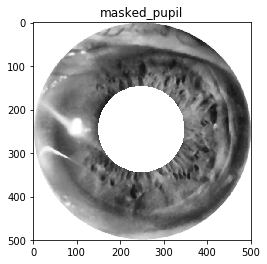

In [8]:
img = cv.cvtColor(blur_clahe.copy(), cv.COLOR_GRAY2RGB)

_, thresh = cv.threshold(blur_clahe, 10, 255, cv.THRESH_BINARY_INV)
    
contours, hierarchy = cv.findContours(thresh, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
maxContour = 0
for contour in contours:
    contourSize = cv.contourArea(contour)
    if contourSize > maxContour:
        maxContour = contourSize
        maxContourData = contour
# Find enclosing circle to pupil
(x,y), r = cv.minEnclosingCircle(maxContourData)
center = (int(x), int(y))
radius = int(r)
masked_pupil = cv.circle(img, center, radius+10, (255,255,255), -1)
display(img, 'masked_pupil')

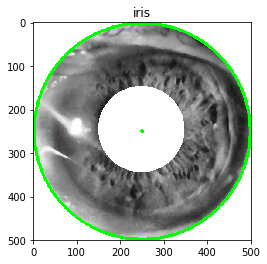

In [9]:
img = cv.cvtColor(masked_pupil.copy(), cv.COLOR_RGB2GRAY)
iris_img = masked_pupil.copy()

circles = cv.HoughCircles(img, cv.HOUGH_GRADIENT,1, int(image.shape[0]), param1=50, param2=50)
if circles is not None:
    circles = np.uint16(np.around(circles))
    for (x,y,r) in circles[0,:]:
        iris_center = (int(x), int(y))
        iris_radius = int(r)
        iris = cv.circle(iris_img, iris_center, iris_radius, (0,255,0),5)
        iris = cv.circle(iris_img, iris_center, 2, (0,255,0), 5)

display(iris, 'iris')

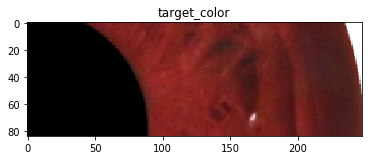

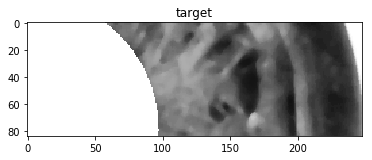

In [10]:
target_color = image[int(iris_center[1]-iris_center[1]/3): int(iris_center[1]), int(iris_center[0]):int(iris_center[0]+iris_radius)]
display(target_color,'target_color')

target = img[int(iris_center[1]-iris_center[1]/3): int(iris_center[1]), int(iris_center[0]):int(iris_center[0]+iris_radius)]
display(target, 'target')

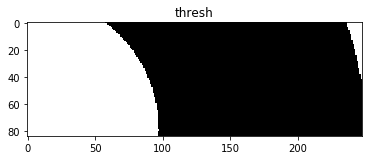

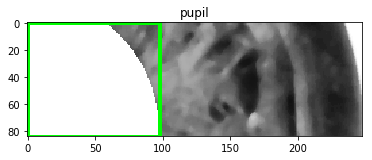

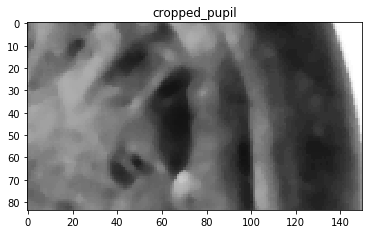

In [11]:
img = cv.cvtColor(target.copy(), cv.COLOR_GRAY2RGB)

_,thresh = cv.threshold(target, 250, 255, cv.THRESH_BINARY)
display(thresh, 'thresh')

contours, hierarchy = cv.findContours(thresh, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
maxContour = 0
for contour in contours:
    contourSize = cv.contourArea(contour)
    if contourSize > maxContour:
        maxContour = contourSize
        maxContourData = contour
    
rect = cv.boundingRect(maxContourData)
x,y,w,h = rect
pupil = cv.rectangle(img, (x,y), (x+w, y+h), (0,255,0), 2)
display(pupil, 'pupil')

crop_target = target[0:, x+w:]
display(crop_target, 'cropped_pupil')

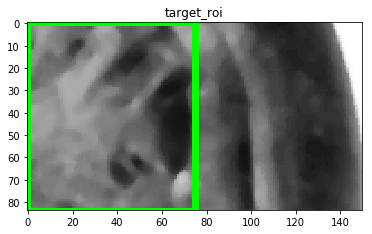

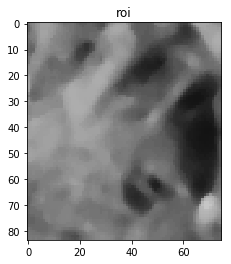

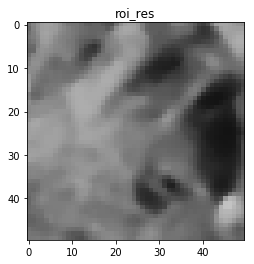

In [12]:
img = cv.cvtColor(crop_target.copy(), cv.COLOR_GRAY2RGB)

[y,x] = crop_target.shape

target_roi = cv.rectangle(img, (0,0), (int(x/2), y), (0,255,0), 2)
display(target_roi, 'target_roi')

roi = crop_target[0:, 0:int(x/2)]
display(roi, 'roi')

roi_res = cv.resize(roi, (50,50))
display(roi_res, 'roi_res')

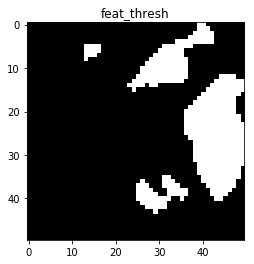

In [15]:
_, thresh = cv.threshold(roi_res, 75, 255, cv.THRESH_BINARY_INV)
display(thresh, 'feat_thresh')

# canny = cv.Canny(thresh, 100,200)
# display(canny, 'feat_canny')

# canny2 = cv.Canny(roi_res, 20, 60)
# display(canny2, 'feat_canny_noThresh')

In [14]:
img_feat = thresh.flatten()
pd.DataFrame(np.asarray(img_feat)).to_csv('img_feat.csv', header=False, index=False)